In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time

from B_data import create_residual_data, create_IC_data, initial_u,exact_u, create_BC_data, create_RH_data,create_RH_data_endt,Move_Time_1D,burgersDdt_godunov,godunov,exact_u_err
from B_Plotting import Burgers_plot, loss_plot 
from scipy.integrate import solve_ivp

# Full PINN
from B_PINN import NN
from B_PINN_train import pinn_train

# Burgers VGPT-PINN
from B_VGPT_activation import P
from B_VGPT_PINN import GPT
from B_VGPT_train import gpt_train

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
# Training Parameter Set
number_of_parameters = 5
nu1_training = np.linspace(0.5, 1.5, number_of_parameters)
nu2_training  = np.linspace(0.0, 0.0,1)

nu_training = []
for i in range(nu1_training.shape[0]):
    for j in range(nu2_training.shape[0]):
        nu_training.append([nu1_training[i],nu2_training[j]])
nu_training = np.array(nu_training)

nu_pinn_train = [1.0,0.0]
number_of_neurons = 1
P_list = np.ones(number_of_neurons, dtype=object) 

In [3]:
# Domain and Data
Xi, Xf         = 0.0, 1.0
Ti, Tf         =  0.0, 1.0
Nx_train, Nt_train =  101, 201
Nx_test, Nt_test = 101, 201
IC_pts, IC_simple = 100, 100
BC_pts =  100
N_RH = IC_pts
dx = 0.001
dt = 0.0002

residual_data = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid      = residual_data[0].to(device)
f_hat         = residual_data[1].to(device)
xt_test       = residual_data[2].to(device)
xt_RHL      = residual_data[3].to(device)
xt_RHR      = residual_data[4].to(device)
xt_RHt         = residual_data[5].to(device)
xt_RHtL       = residual_data[6].to(device)

IC_x_test     = xt_test[0:Nx_test,:1].squeeze().cpu()
IC_t_test     = xt_test[0:Nx_test*Nt_test:Nx_test,1:].squeeze().cpu()

Nx_test0, Nt_test0 = 1001, 2001
xt_test0 = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test0, Nt_test0, dx,dt)[2].to(device)
IC_x_test0     = xt_test0[0:Nx_test0,:1].squeeze().cpu()
IC_t_test0     = xt_test0[0:Nx_test0*Nt_test0:Nx_test0,1:].squeeze().cpu()   

BC_data = create_BC_data(Xi, Xf, Ti, Tf, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

#xt_RH_data = create_RH_data(Xi, Xf, Ti, Tf, IC_pts, N_RH,dx)
#xt_RH = xt_RH_data[0].to(device)
#xt_RHL = xt_RH_data[1].to(device)

In [4]:
# Setting PINN and TGPT-PINN
# Setting PINN and TGPT-PINN
layers_pinn = np.array([2, 30, 30, 30, 30, 30, 1])

lr_pinn     = 0.001
epochs_pinn = 60000
tol_pinn    = 1e-5

pinn_train_times = np.ones(number_of_neurons)

###############################################################################
################################ Training Loop ################################
###############################################################################

In [7]:
import pickle
P_name=f"IFNN_shock3.pkl"
with open(P_name, 'rb') as f:
    P_list = pickle.load(f)

[0.5 0. ] stopped at epoch: 0 | gpt_loss: 1.299712061882019,rMAE: [0.5400477906006562], rRMSE:[0.7165309547294616], 0.062200237065553665, 0.12375117838382721, 9.566160308338567e-09, 1.2101540472833627e-12
[0.5 0. ] stopped at epoch: 500 | gpt_loss: 0.0003135251463390887,rMAE: 0.030420582303054024, rRMSE:0.10120406127112651, 0.0002936800883617252, 1.8852226730814436e-06, 9.92808182331828e-08, 2.030509224301702e-12
[0.5 0. ] stopped at epoch: 1000 | gpt_loss: 0.0003147810057271272,rMAE: 0.030841307194444795, rRMSE:0.10096927558213017, 0.0003116674197372049, 2.8696828735519375e-07, 2.4386126895592497e-08, 2.253244682851041e-12
[0.5 0. ] stopped at epoch: 1500 | gpt_loss: 0.0003147773095406592,rMAE: 0.03084153427193602, rRMSE:0.10096933879135278, 0.00031166401458904147, 2.869525133064599e-07, 2.4373788320986023e-08, 2.2533238296096325e-12
[0.5 0. ] stopped at epoch: 2000 | gpt_loss: 0.0003147759707644582,rMAE: 0.0308415165300053, rRMSE:0.10096937109482132, 0.00031166261760517955, 2.8694910

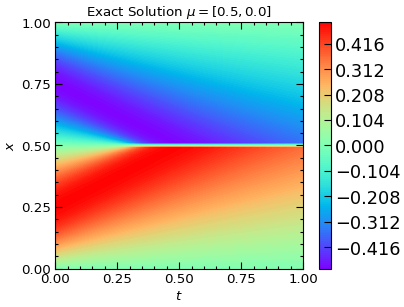

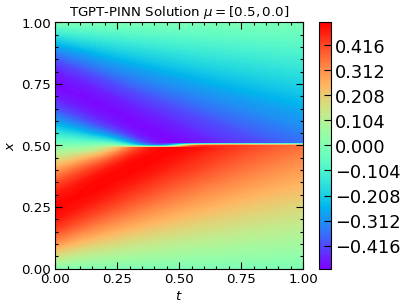

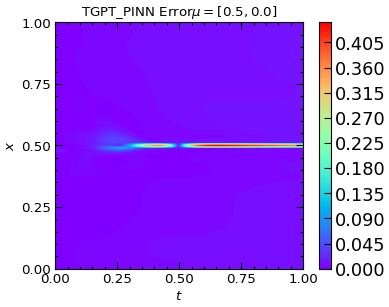

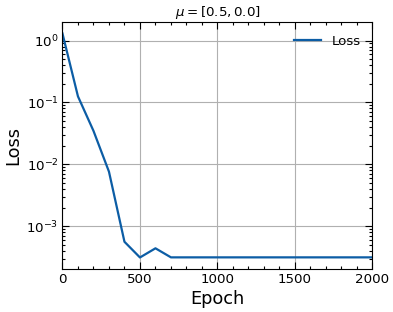

GPT-PINN at [0.5 0. ] with the Loss=0.0003147759707644582, rMAE = 0.0308415165300053, rRMSE = 0.10096937109482132


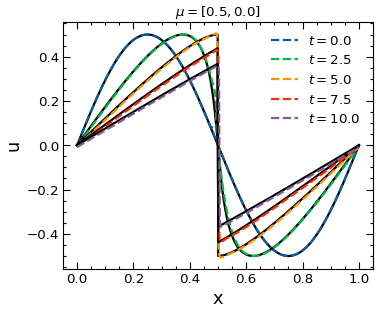

[0.75 0.  ] stopped at epoch: 0 | gpt_loss: 0.32493507862091064,rMAE: [0.19409426950905728], rRMSE:[0.2889198184366785], 0.015553880482912064, 0.030938109382987022, 9.566160308338567e-09, 1.2101540472833627e-12
layer1:tensor([[ 1.0000e+00,  1.0095e-05],
        [-1.3618e-04,  7.5119e-01]], device='cuda:0') and tensor([2.0132e-05, 5.0942e-05], device='cuda:0') and layer3:tensor([[0.7506]], device='cuda:0')
[0.75 0.  ] stopped at epoch: 122 | gpt_loss: 8.606797564425506e-06 ,rMAE: 0.019835259467982706, rRMSE:0.1278334869441925(GPT_PINN Stopping Criteria Met)



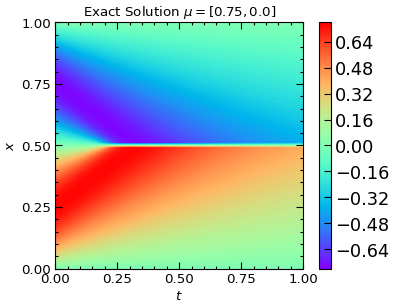

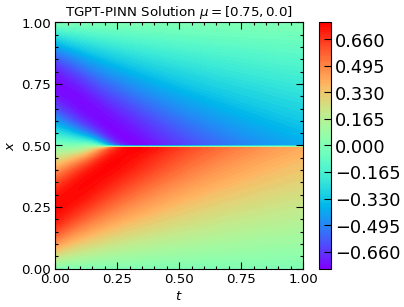

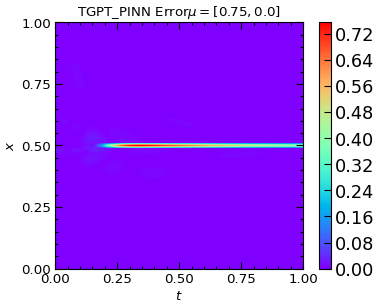

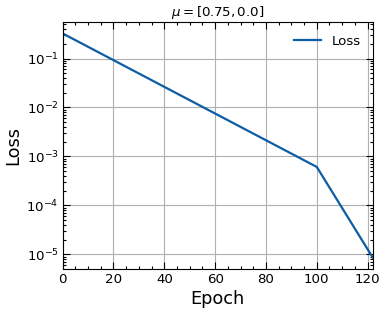

GPT-PINN at [0.75 0.  ] with the Loss=8.606797564425506e-06, rMAE = 0.019835259467982706, rRMSE = 0.1278334869441925


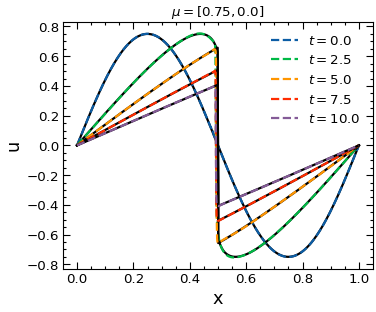

[1. 0.] stopped at epoch: 0 | gpt_loss: 9.899229553411715e-06,rMAE: [0.021329604173111964], rRMSE:[0.13212727237464658], 9.42625047173351e-06, 3.773059020772962e-08, 9.566160308338567e-09, 1.2101540472833627e-12
layer1:tensor([[1., 0.],
        [0., 1.]], device='cuda:0') and tensor([0., 0.], device='cuda:0') and layer3:tensor([[1.]], device='cuda:0')
[1. 0.] stopped at epoch: 1 | gpt_loss: 9.899229553411715e-06 ,rMAE: 0.021329604173111964, rRMSE:0.13212727237464658(GPT_PINN Stopping Criteria Met)



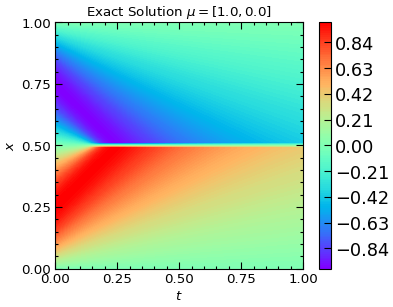

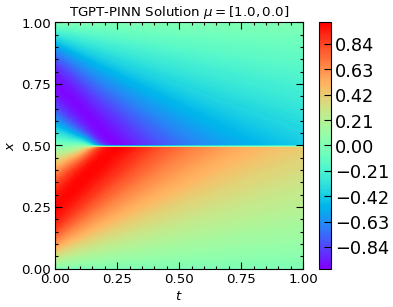

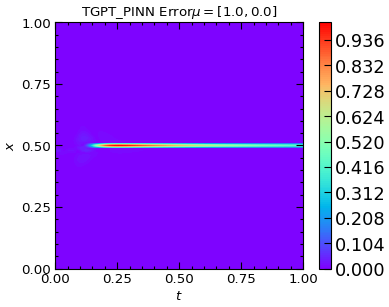

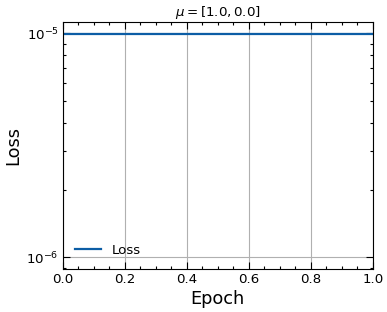

GPT-PINN at [1. 0.] with the Loss=9.899229553411715e-06, rMAE = 0.021329604173111964, rRMSE = 0.13212727237464658


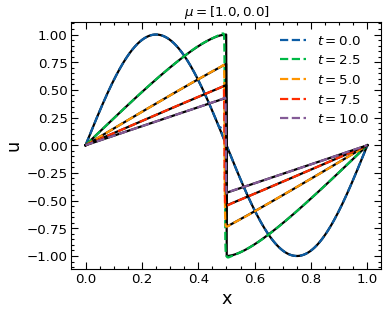

[1.25 0.  ] stopped at epoch: 0 | gpt_loss: 0.32493656873703003,rMAE: [0.11320109619592594], rRMSE:[0.19041234728351242], 0.0155668705701828, 0.030936960130929947, 9.566160308338567e-09, 1.2101540472833627e-12
[1.25 0.  ] stopped at epoch: 500 | gpt_loss: 0.0007287538610398769,rMAE: 0.0252874749359232, rRMSE:0.13466905294056356, 0.0005994587554596364, 1.8647180866082635e-07, 5.117530932352565e-08, 1.269186850549886e-05
[1.25 0.  ] stopped at epoch: 1000 | gpt_loss: 0.0007287258049473166,rMAE: 0.025287326500670847, rRMSE:0.13466920090456946, 0.000599425402469933, 1.8700791315495735e-07, 5.116847034969396e-08, 1.269186850549886e-05
[1.25 0.  ] stopped at epoch: 1500 | gpt_loss: 0.0007287837797775865,rMAE: 0.025287054263961294, rRMSE:0.13466906051021008, 0.0005994905368424952, 1.8630811382536194e-07, 5.1146987090078255e-08, 1.269186850549886e-05
[1.25 0.  ] stopped at epoch: 2000 | gpt_loss: 0.0007287856424227357,rMAE: 0.02528748871506472, rRMSE:0.13466905944628754, 0.0005994930979795754,

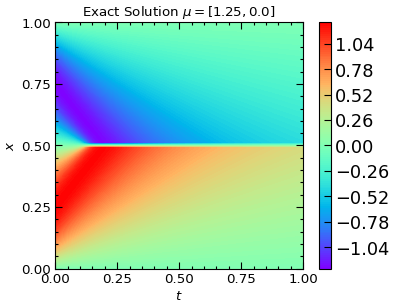

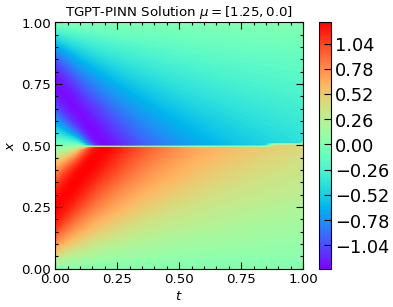

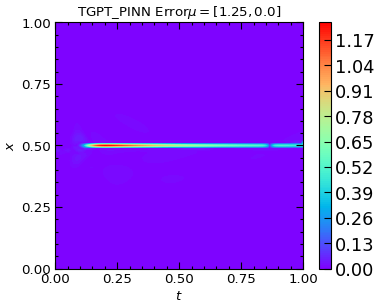

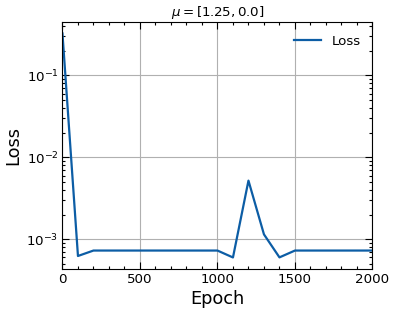

GPT-PINN at [1.25 0.  ] with the Loss=0.0007287856424227357, rMAE = 0.02528748871506472, rRMSE = 0.13466905944628754


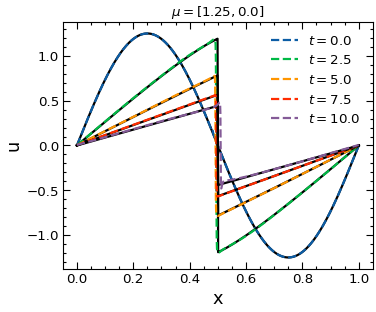

[1.5 0. ] stopped at epoch: 0 | gpt_loss: 1.2997150421142578,rMAE: [0.1850331120951862], rRMSE:[0.2791406146003365], 0.06222621724009514, 0.12374888360500336, 9.566160308338567e-09, 1.2101540472833627e-12
[1.5 0. ] stopped at epoch: 500 | gpt_loss: 0.0032648879569023848,rMAE: 0.034080921796913285, rRMSE:0.15687989413326617, 0.0032494226470589638, 2.862647932033724e-07, 1.2602550896190223e-06, 9.974835193937714e-12
[1.5 0. ] stopped at epoch: 1000 | gpt_loss: 0.0032713464461266994,rMAE: 0.03437522400702929, rRMSE:0.1571065443700504, 0.0032431648578494787, 1.4956312952563167e-06, 1.322538309977972e-06, 1.1090846123440468e-11
[1.5 0. ] stopped at epoch: 1500 | gpt_loss: 0.003422456094995141,rMAE: 0.03474037555258972, rRMSE:0.157100057285456, 0.0033648351673036814, 4.304667527321726e-06, 1.4574305851056124e-06, 1.117578772580341e-11
[1.5 0. ] stopped at epoch: 2000 | gpt_loss: 0.003057931549847126,rMAE: 0.03333170846889728, rRMSE:0.1591063563823091, 0.0030423845164477825, 1.705781897953784

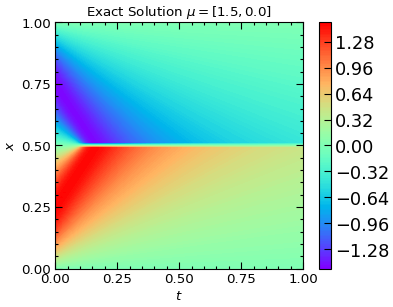

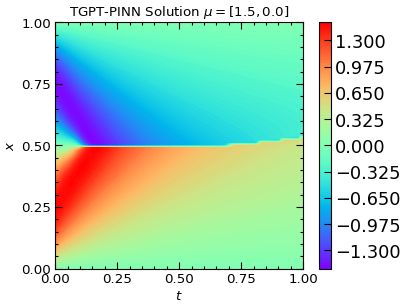

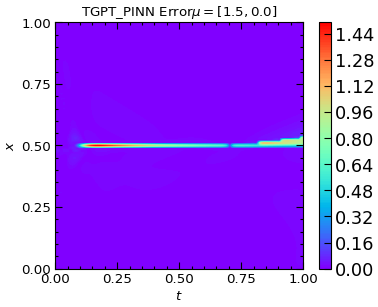

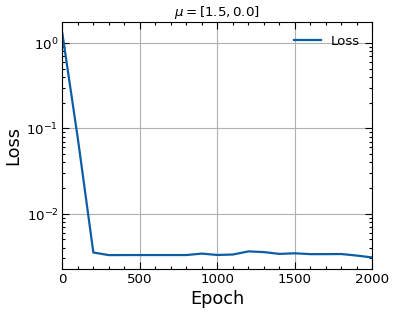

GPT-PINN at [1.5 0. ] with the Loss=0.003057931549847126, rMAE = 0.03333170846889728, rRMSE = 0.1591063563823091


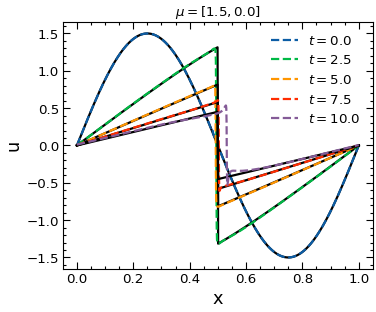

Largest Loss: 0.003057931549847126 at [1.5 0. ]
Largest L1: 0.03333170846889728 at [1.5 0. ]
Largest L2: 0.1591063563823091 at [1.5 0. ]
Loss:[0.0003147759707644582, 8.606797564425506e-06, 9.899229553411715e-06, 0.0007287856424227357, 0.003057931549847126]
L1:[0.0308415165300053, 0.019835259467982706, 0.021329604173111964, 0.02528748871506472, 0.03333170846889728]
L2:[0.10096937109482132, 0.1278334869441925, 0.13212727237464658, 0.13466905944628754, 0.1591063563823091]


In [6]:
i=0
nu_pinn_train   =1.0    
lr_gpt          = 0.005
epochs_gpt      = 2000
tol_gpt         = 1e-5
############################ VGPT-PINN Training ############################
layers_gpt = np.array([2, i+1, 1])
c_initial  = torch.full((1,i+1), 1/(i+1))
nu_loss = []
L1_err  = []
L2_err  = []
Cor_err =  []

gpt_train_time_1 = time.perf_counter()
for nu in nu_training:
    IC_u_test = initial_u(nu,IC_x_test)
    God_sol=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test.cpu(), t_eval=IC_t_test)
    Exact_y0 = torch.from_numpy(God_sol.y.T.reshape(xt_test.shape[0],1)).to(device)

    IC_data = create_IC_data(nu, Xi, Xf, Ti, Tf, IC_pts, IC_simple)
    IC_xt     = IC_data[0].to(device)
    IC_u      = IC_data[1].to(device)

    #print((P_list[0]).linears[0].bias)
    GPT_PINN = GPT(nu, layers_gpt, P_list[0:i+1], c_initial,xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u,  BC1, BC2,xt_RHL,xt_RHR,xt_RHt,xt_RHtL,Nx_train,Nt_train,dt).to(device)

    gpt_losses = gpt_train(GPT_PINN, nu, xt_resid, f_hat, Exact_y0, xt_test, IC_xt, IC_u, BC1, BC2, epochs_gpt, lr_gpt, tol_gpt)

    nu_loss.append(gpt_losses[0].item())
    L1_err.append(gpt_losses[3][-1])
    L2_err.append(gpt_losses[4][-1])


    Burgers_plot(xt_test, Exact_y0, Nx_test,Nt_test,title=fr"Exact Solution $\mu=[{nu[0]},{nu[1]}]$")
    Burgers_plot(xt_test, GPT_PINN.forward(xt_test), Nx_test,Nt_test,title=fr"TGPT-PINN Solution $\mu=[{nu[0]},{nu[1]}]$")
    Burgers_plot(xt_test, abs(GPT_PINN.forward(xt_test)-Exact_y0), Nx_test,Nt_test,title=fr"TGPT_PINN Error$\mu=[{nu[0]},{nu[1]}]$")

    plt.figure(dpi=80, figsize=(5,4))    
    plt.plot(gpt_losses[1], gpt_losses[2], label="Loss")
    #plt.plot(gpt_losses[1], gpt_losses[3], label="L1 error")
    #plt.plot(gpt_losses[1], gpt_losses[4], label="L2 error")
    #plt.plot(gpt_losses[1], gpt_losses[5], label="Loss_implict")
    #plt.plot(gpt_losses[1], gpt_losses[8], label="Loss_Res")
    #plt.plot(gpt_losses[1], gpt_losses[6], label="Loss_IC")
    #plt.plot(gpt_losses[1], gpt_losses[7], label="Loss_BC")

    plt.xlabel("Epoch",     fontsize=16)
    plt.ylabel("Loss", fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    
    plt.grid(True)
    plt.xlim(0,max(gpt_losses[1]))
    plt.yscale('log')
    plt.title(fr"$\mu=[{nu[0]},{nu[1]}]$", fontsize=12)
    plt.legend(fontsize = 12)#
    plt.show()

    #err =exact_u_err(Exact_y0,GPT_PINN(xt_test),xt_test,nu)[1]
    #Cor_err.append(err.item())
    #print(f"VGPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]} and Cor error = {err.item()}")
    print(f"VGPT-PINN at {nu} with the Loss={gpt_losses[0].item()}, rMAE = {gpt_losses[3][-1]}, rRMSE = {gpt_losses[4][-1]}")

    IC_u_test0 = initial_u(nu,IC_x_test0)
    God_sol0=solve_ivp(burgersDdt_godunov, t_span=(0, Tf), y0=IC_u_test0.cpu(), t_eval=IC_t_test0)
    Exact_y0 = torch.from_numpy(God_sol0.y.T.reshape(xt_test0.shape[0],1)).to(device)  
    PINN_y0 = GPT_PINN.forward(xt_test0)
    plt.figure(dpi=80, figsize=(5,4))#dpi=150, figsize=(10,8)
    for ind in range(1, Nt_test0+1,500):
        plt.plot(xt_test0[0:Nx_test0,0].detach().cpu(),Exact_y0[(ind-1)*Nx_test0:ind*Nx_test0,0].detach().cpu(),'k')
        #plt.scatter(xt_test[0:Nx_test,0].detach().cpu(),PINN(xt_test)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),s=20,label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
        plt.plot(xt_test0[0:Nx_test0,0].detach().cpu(),PINN_y0[(ind-1)*Nx_test0:ind*Nx_test0,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.xlabel("x",     fontsize=16)
    plt.ylabel("u", fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.title(fr"$\mu=[{nu[0]},{nu[1]}]$", fontsize=12)
    plt.legend(fontsize = 12)#
    plt.show()

        
print(f"Largest Loss: {max(nu_loss)} at {nu_training[nu_loss.index(max(nu_loss))]}")
print(f"Largest L1: {max(L1_err)} at {nu_training[L1_err.index(max(L1_err))]}")
print(f"Largest L2: {max(L2_err)} at {nu_training[L2_err.index(max(L2_err))]}") 

print(f"Loss:{nu_loss}")
print(f"L1:{L1_err}")
print(f"L2:{L2_err}")